In [2]:
from collections import defaultdict as ddict, OrderedDict as odict
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bayes_opt import BayesianOptimization
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.Chem.Descriptors import MolWt
from sklearn.ensemble import RandomForestRegressor
import sklearn
from rdkit.Chem.rdmolops import GetFormalCharge
import torch
import deepchem as dc
import statsmodels.api as sm

import imp

from joypy import joyplot

RDKit WARNING: [18:22:17] Enabling RDKit 2019.09.3 jupyter extensions


In [466]:
data = pd.read_csv('data/full_pka_data.csv')
solute = data['Solute SMILES'].tolist()
solvent = data['Solvent SMILES'].tolist()
pka = data['pKa (avg)'].tolist()
acids = data['Acid type'].tolist()
solvent_names = data['Solvent name'].to_list()
size = len(solute)
print(size)
sol_solv_pairs = [(solute[x],solvent[x]) for x in range(size)]

3222


In [450]:
print(solv_set)
solvent_name_key = {"CS(=O)C":"DMSO","CC#N":"acetonitrile","C(CCl)Cl":"DCE","CN(C)C=O":"DMF","C1CCOC1":"THF","O":"water"}
solvent_names = [solvent_name_key[solv] for solv in solvent]

['CS(=O)C', 'CC#N', 'C(CCl)Cl', 'CN(C)C=O', 'C1CCOC1', 'O']


In [467]:
#sizes
sol_set = list(set(solute))
solv_set = list(set(solvent))
print('# of unique solutes: ', len(sol_set))
print('# of unique solvents: ', len(solv_set))

# of unique solutes:  2760
# of unique solvents:  6


In [152]:
print(solv_set)
solvent_dielectric_key = [46.68,10.36,36.71,80.1,7.58,37.5]
solvent_dielectrics = [solvent_dielectric_key[solv_set.index(solv)] for solv in solvent]
solvent_polarity_key = [4.1,1.83,3.86,1.87,1.75,3.44]
solvent_polarities = [solvent_polarity_key[solv_set.index(solv)] for solv in solvent]

['CS(=O)C', 'C(CCl)Cl', 'CN(C)C=O', 'O', 'C1CCOC1', 'CC#N']


In [45]:
print(solute_s[1],solvent_s[1],pka_s[1])

C1=C[NH2+]C=N1 C1CCOC1 1.4


In [45]:
#solvent sizes
print('# of solutes in each solvent:')
for solv in solv_set:
    print(solv,':',solvent.count(solv))

# of solutes in each solvent:
CS(=O)C : 130
CC#N : 400
C(CCl)Cl : 88
CN(C)C=O : 20
C1CCOC1 : 65
O : 2519


# of solutes in CS(=O)C : 130


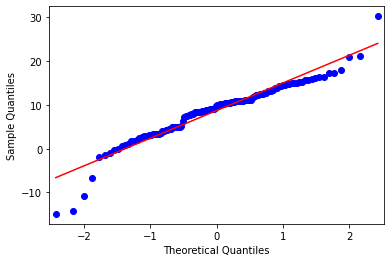

shapiro: 1.7842326997197233e-05
# of solutes in C(CCl)Cl : 88


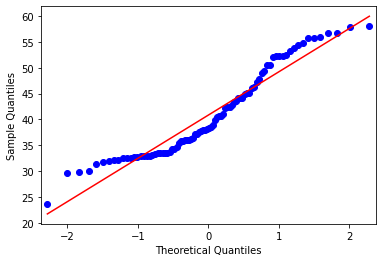

shapiro: 9.448809578316286e-05
# of solutes in CN(C)C=O : 20


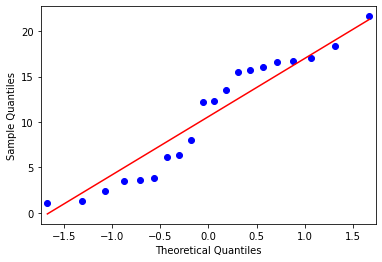

shapiro: 0.06562642008066177
# of solutes in O : 2519


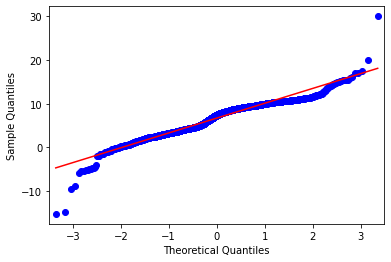

shapiro: 6.600642920418668e-28
# of solutes in C1CCOC1 : 65


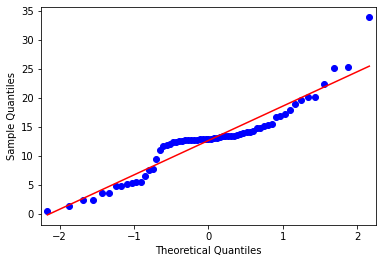

shapiro: 0.0006868900381959975
# of solutes in CC#N : 400


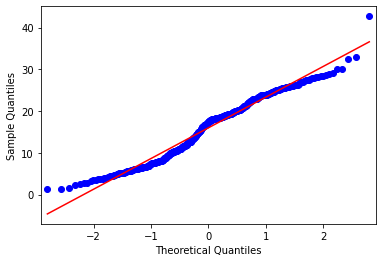

shapiro: 2.9742560059276e-07


In [154]:
#solvent distributions

import statsmodels.api as sm
from scipy.stats import norm
import pylab
from scipy.stats import shapiro

for solv in solv_set:
    print('# of solutes in',solv,':',solvent.count(solv))
    ids = [i for i,x in enumerate(solvent) if x == solv]
    pkas = np.array([pka[x] for x in ids])
    sm.qqplot(pkas, line='s')
    pylab.show()
    print('shapiro:',shapiro(pkas)[1])
    
#all are not normally distributed, except for CN(C)C=O

In [46]:
#solutes with multiple solvents
multisolv_sol = ddict(list)
for sol in sol_set:
    indices = [i for i,x in enumerate(solute) if x == sol]
    pkas = [pka[i] for i in indices]
    solvents = [solvent[i] for i in indices]
    multisolv_sol[sol].append(solvents)
    multisolv_sol[sol].append(pkas)
    
for x in range(1,7):
    i=0
    for sol in sol_set:
        if len(multisolv_sol[sol][0])==x:
            i+=1
    print(str(i)+" solutes with "+str(x)+" solvents")

2498 solutes with 1 solvents
153 solutes with 2 solvents
30 solutes with 3 solvents
73 solutes with 4 solvents
6 solutes with 5 solvents
1 solutes with 6 solvents


In [46]:
#solvent dielectric
multisolv_sol = ddict(list)
for sol in sol_set:
    indices = [i for i,x in enumerate(solute) if x == sol]
    pkas = [pka[i] for i in indices]
    solvents = [solvent_dielectrics[i] for i in indices]
    solvents, pkas = (list(t) for t in zip(*sorted(zip(solvents, pkas))))
    multisolv_sol[sol].append(solvents)
    multisolv_sol[sol].append(pkas)

In [84]:
#solvent polarity
multisolv_sol = ddict(list)
for sol in sol_set:
    indices = [i for i,x in enumerate(solute) if x == sol]
    pkas = [pka[i] for i in indices]
    solvents = [solvent_polarities[i] for i in indices]
    solvents, pkas = (list(t) for t in zip(*sorted(zip(solvents, pkas))))
    multisolv_sol[sol].append(solvents)
    multisolv_sol[sol].append(pkas)

In [47]:
multisolv_sol[solute[0]]

[[7.58, 37.5, 46.68, 80.1], [20.2, 26.025, 15.3, 15.2]]

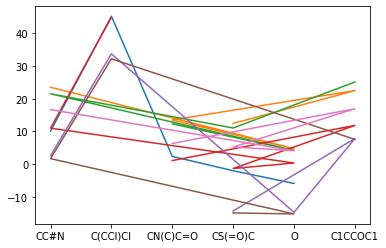

In [89]:
for sol in sol_set:
    if len(multisolv_sol[sol][0])>4:
        plt.plot(*multisolv_sol[sol])
plt.show()

In [156]:
#solvent intersections
multisolv_sol = ddict(list)
for sol in sol_set:
    indices = [i for i,x in enumerate(solute) if x == sol]
    pkas = [pka[i] for i in indices]
    solvents = [solvent[i] for i in indices]
    multisolv_sol[sol].append(solvents)
    multisolv_sol[sol].append(pkas)

solv_n = ddict(list)
for solv1 in solv_set:
    solv_n['solvents'].append(solv1)
    for solv2 in solv_set:
        if solv1 == solv2:
            i='x'
        else:
            i=0
            for sol in sol_set:
                solvs = multisolv_sol[sol][0]
                pkas = multisolv_sol[sol][1]
                if solv1 in solvs and solv2 in solvs:
                    i+=1
        solv_n[solv2].append(i)
        
solv_n = pd.DataFrame(solv_n)
print(solv_n)

   solvents CS(=O)C C(CCl)Cl CN(C)C=O    O C1CCOC1 CC#N
0   CS(=O)C       x       19       15   97      63  130
1  C(CCl)Cl      19        x        2   12       3   59
2  CN(C)C=O      15        2        x   16       4   20
3         O      97       12       16    x      64  187
4   C1CCOC1      63        3        4   64       x   65
5      CC#N     130       59       20  187      65    x


number of solutes: 130


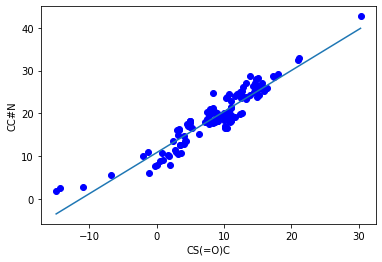

0.9383587427322703
number of solutes: 19


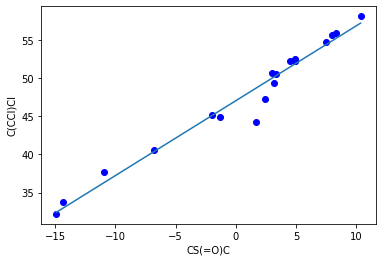

0.9837418366881469
number of solutes: 15


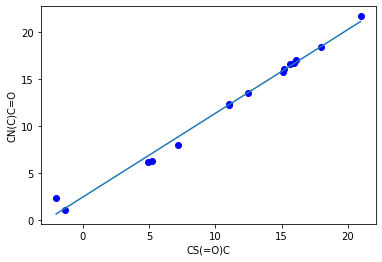

0.9950961803096826
number of solutes: 63


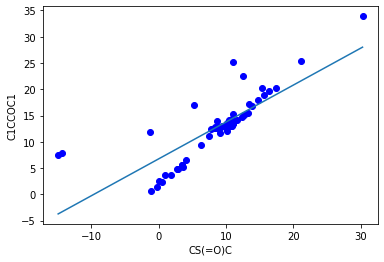

0.8014586830890716
number of solutes: 97


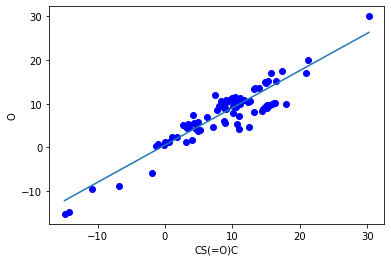

0.919896425795915
number of solutes: 59


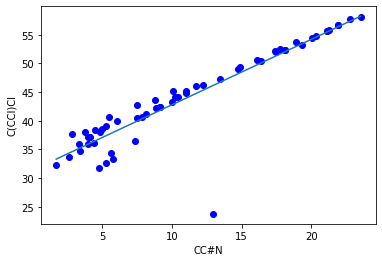

0.9091504326139894
number of solutes: 20


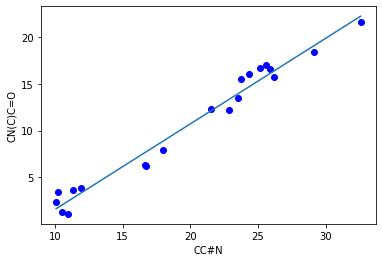

0.9869197959785981
number of solutes: 65


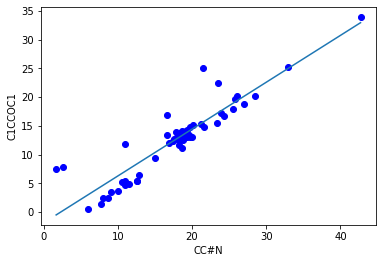

0.9085645586095638
number of solutes: 187


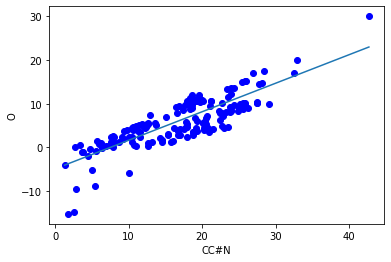

0.828736337639178
number of solutes: 2


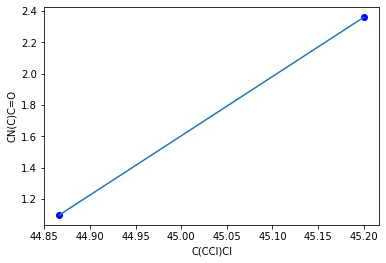

1.0
number of solutes: 3


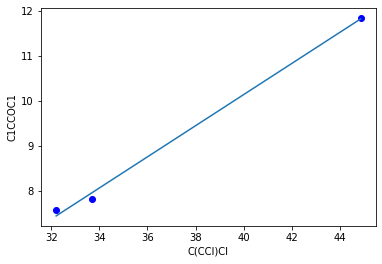

0.9985289971606158
number of solutes: 12


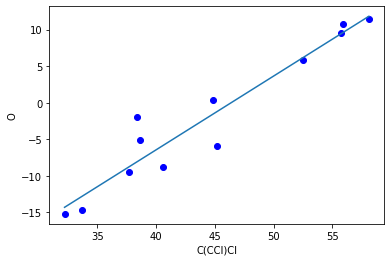

0.9568356053346798
number of solutes: 4


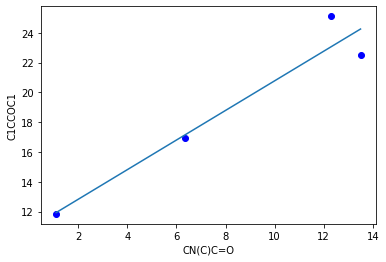

0.9641514751638561
number of solutes: 16


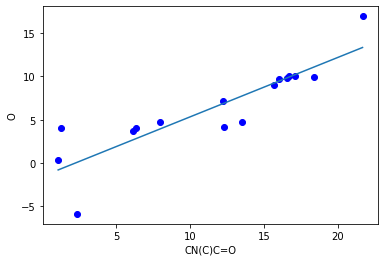

0.8741960833536212
number of solutes: 64


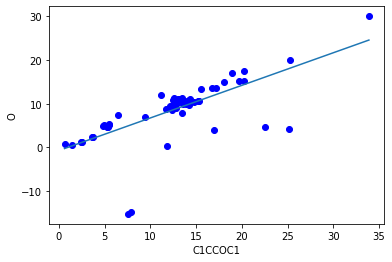

0.6843186457402592


In [47]:
#double solvent correlations
import itertools
import scipy.stats
pairs = list(itertools.combinations(solv_set, 2))
for (solv1, solv2) in pairs:
    solv1_list = []
    solv2_list = []

    multisolv_sol = ddict(list)
    for sol in sol_set:
        indices = [i for i,x in enumerate(solute) if x == sol]
        pkas = [pka[i] for i in indices]
        solvents = [solvent[i] for i in indices]
        multisolv_sol[sol].append(solvents)
        multisolv_sol[sol].append(pkas)

    for sol in sol_set:
        solvs = multisolv_sol[sol][0]
        pkas = multisolv_sol[sol][1]
        if solv1 in solvs and solv2 in solvs:
            solv1_list.append(pkas[solvs.index(solv1)])
            solv2_list.append(pkas[solvs.index(solv2)])
    print("number of solutes: "+str(len(solv1_list)))

    x = np.array(solv1_list)
    y = np.array(solv2_list)

    plt.plot(x, y, 'bo')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.xlabel(solv1)
    plt.ylabel(solv2)
    plt.show()
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    print(r_value)

number of solutes: 97
CS(=O)C 0.9198964257959841
number of solutes: 187
CC#N 0.8287363376400748
number of solutes: 12
C(CCl)Cl 0.9568356053411563
number of solutes: 16
CN(C)C=O 0.8741960833540156
number of solutes: 64
C1CCOC1 0.684318645739858


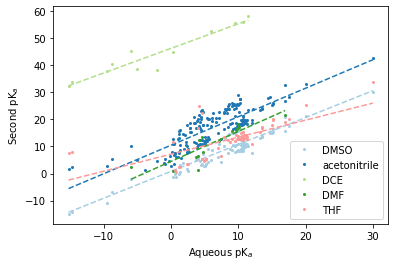

In [509]:
#double solvent correlation w water
import itertools
import scipy.stats
pairs = [('O',solv) for solv in solv_set if solv not in 'O']
i=0
for (solv1, solv2) in pairs:
    solv1_list = []
    solv2_list = []

    multisolv_sol = ddict(list)
    for sol in sol_set:
        indices = [i for i,x in enumerate(solute) if x == sol]
        pkas = [pka[i] for i in indices]
        solvents = [solvent[i] for i in indices]
        multisolv_sol[sol].append(solvents)
        multisolv_sol[sol].append(pkas)

    for sol in sol_set:
        solvs = multisolv_sol[sol][0]
        pkas = multisolv_sol[sol][1]
        if solv1 in solvs and solv2 in solvs:
            solv1_list.append(pkas[solvs.index(solv1)])
            solv2_list.append(pkas[solvs.index(solv2)])
    print("number of solutes: "+str(len(solv1_list)))

    x = np.array(solv1_list)
    y = np.array(solv2_list)

    plt.plot(x, y, 'o', color=colours[i], label=solvent_name_key[solv2], markersize=2)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), '--', color=colours[i])
    i+=1
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    print(solv2, r_value)
    
plt.xlabel('Aqueous pK$_a$')
plt.ylabel('Second pK$_a$')
plt.legend()
plt.savefig('solv_corr.png')
plt.show()

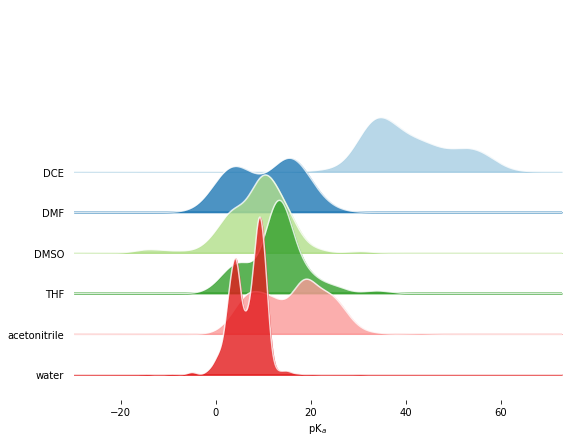

In [510]:
#pka spread in solvents
colours = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
total = ['total']*len(solvent_names)
new_df = pd.DataFrame({'pKa':pka+pka,'Solvent name':solvent_names+total})

joyplot(
    data=data[['pKa (avg)','Solvent name']], 
    by='Solvent name',
    overlap = 3,
    figsize = (8,6),
    fill=True,
    linecolor='w',
    color=colours,
    fade=False,
    alpha=0.8
)

plt.xlabel('pK$_a$')

plt.savefig('solv_joy.png')
plt.show()

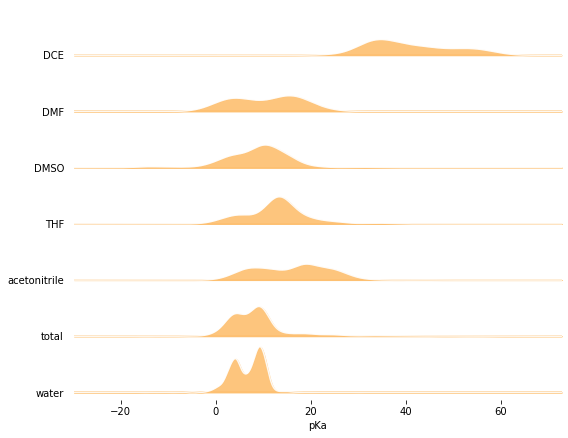

In [171]:
joyplot(
    data=pd.DataFrame({'pKa':pka+pka,'Solvent name':solvent_names+total}),
    by='Solvent name',
    figsize = (8,6),
    overlap = 0,
    fill=True,
    linecolor='w',
    color='#fdbf6f',
    fade=False,
    alpha=0.9
)

plt.xlabel('pKa')

plt.show()

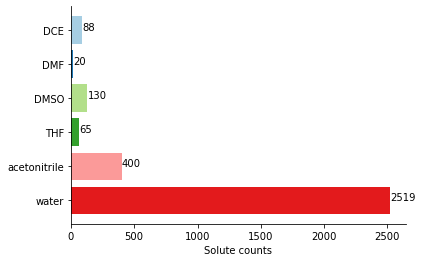

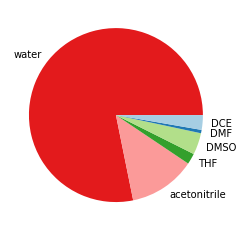

In [468]:
#solvent proportions
solvs = ["DCE","DMF","DMSO","THF","acetonitrile","water"]
counts = [solvent_names.count(solv) for solv in solvs]
colours = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
solvs.reverse()
counts.reverse()
colours.reverse()

fig, ax = plt.subplots()
ax.barh(solvs,counts,color=colours)
plt.xlabel("Solute counts")
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

for index, value in enumerate(counts):
    plt.text(value, index, str(value))

plt.show()

plt.pie(counts, labels = solvs, colors = colours)
plt.show() 

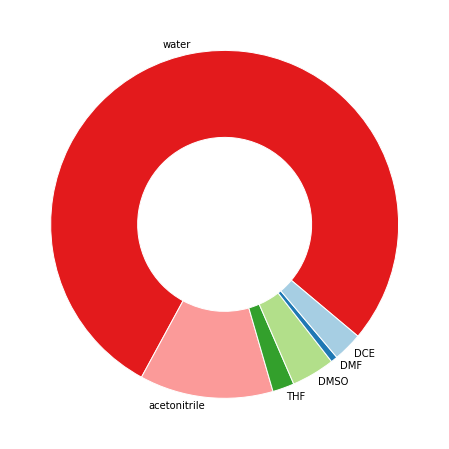

In [469]:
#solvent proportion pie chart
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(counts, wedgeprops=dict(width=0.5), startangle=-40, colors=colours, labels=solvs, labeldistance=1.05)

for wedge in wedges:
    wedge.set_edgecolor('white')

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

plt.savefig('solv_pie.png')
plt.show()

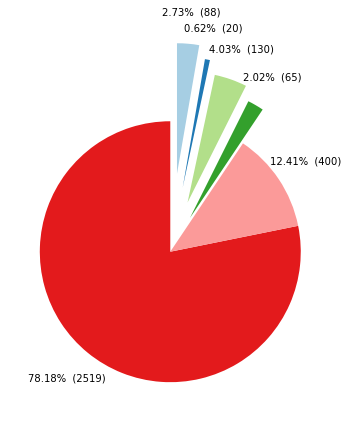

In [470]:
#solvent proportion pie chart
fig1, ax1 = plt.subplots()
explode = (0, 0, 0.3,0.4,0.5,0.6)
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
ax1.pie(counts, colors = colours, autopct=make_autopct(counts), startangle=90, pctdistance=1.25, explode=explode)
fig1.set_size_inches(6,6)
#draw circle
#centre_circle = plt.Circle((0,0),0.70,fc='white')
#fig = plt.gcf()
#fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
#ax1.axis('equal')  
#plt.tight_layout()
plt.savefig('solv_pie.png')
plt.show()

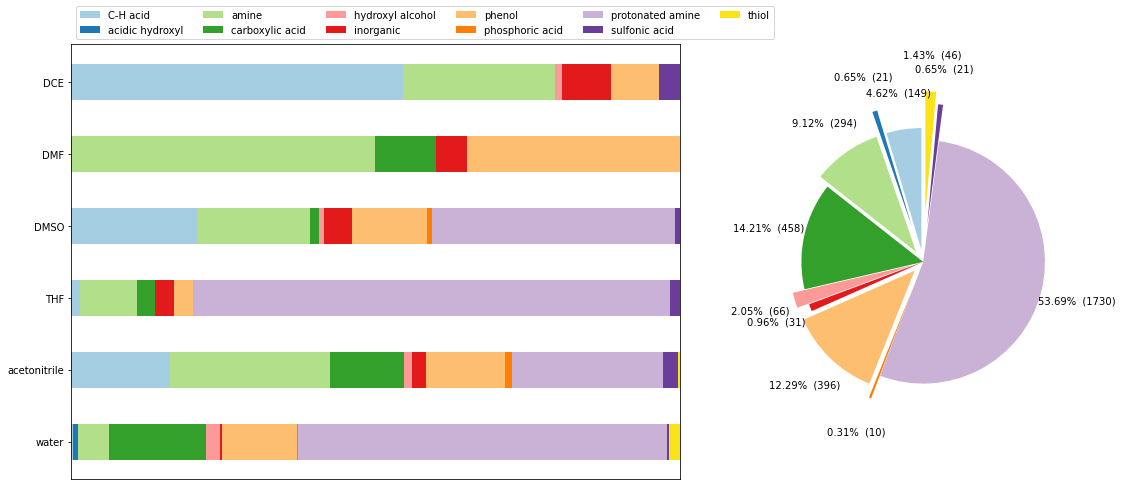

In [514]:
colours = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c',
           '#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#FAE318','#b15928']

d = data.groupby(["Solvent name", "Acid type"])["Acid type"].count()
d = d.to_frame()
d.to_csv('acid_types.csv')
acid_table = pd.pivot_table(pd.read_csv('acid_types.csv'), values="Acid type.1", index="Solvent name", columns="Acid type")
acid_table = acid_table.fillna(0)

classes = acid_table.columns.to_list()
solvs = acid_table.index.to_list()
acid_data = acid_table.to_numpy()
data_cum = acid_data.cumsum(axis=1)

row_max = data_cum[:,-1]
data_cum = data_cum * 100 / row_max[:, np.newaxis]
acid_data = acid_data * 100 / row_max[:, np.newaxis]
category_colors = colours[:11]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,9), gridspec_kw={'width_ratios': [2, 1]})
ax1.invert_yaxis()
ax1.xaxis.set_visible(False)
ax1.set_xlim(0, 100)

for i, (colname, color) in enumerate(zip(classes, category_colors)):
    widths = acid_data[:, i]
    starts = data_cum[:, i] - widths
    rects = ax1.barh(solvs, widths, left=starts, height=0.5,
                    label=colname, color=color)

    text_color = 'white' 
 #   ax.bar_label(rects, label_type='center', color=text_color)
ax1.legend(ncol=6, bbox_to_anchor=(0, 1),
          loc='lower left', fontsize='medium')

explode = (0.1,0.3,0.1,0,0.1,0,0.1,0.2,0,0.3,0.4)
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
ax2.pie(counts, colors = colours, autopct=make_autopct(counts), startangle=90, pctdistance=1.3, explode=explode)
fig.set_size_inches(18,8)

fig.savefig('solv_acids.png')
#plt.show()

In [475]:
counts = [acids.count(name) for name in classes]
print(counts)

[149, 21, 294, 458, 66, 31, 396, 10, 1730, 21, 46]


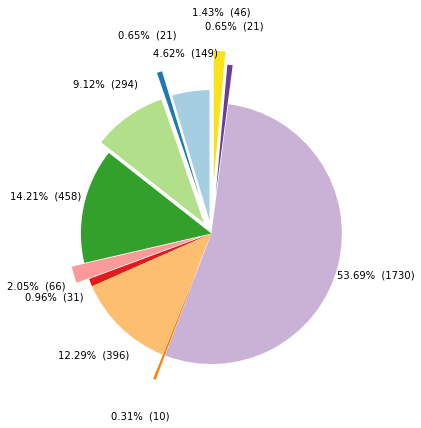

In [489]:
explode = (0.1,0.3,0.1,0,0.1,0,0,0.2,0,0.3,0.4)
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
ax2.pie(counts, colors = colours, autopct=make_autopct(counts), startangle=90, pctdistance=1.3, explode=explode)
fig.set_size_inches(6,6)
#draw circle
#centre_circle = plt.Circle((0,0),0.70,fc='white')
#fig = plt.gcf()
#fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
#ax1.axis('equal')  
#plt.tight_layout()
plt.savefig('solv_pie.png')
plt.show()

In [445]:
solute = data['Solute SMILES'].tolist()
patt_lists = ddict(list)
#solutes = [x for x in sol_set]
acid_list = [('protonated amine','[NH+,NH2+,NH3+,nH+,nH2+,nH3+,N@H+]'),
             ('carboxylic acid','[CX3](=O)[OX2H1]'),
             ('sulfonic acid','[$([#16X4](=[OX1])(=[OX1])([#6])[OX2H,OX1H0-]),$([#16X4+2]([OX1-])([OX1-])([#6])[OX2H,OX1H0-])]'),
             ('phosphoric acid','[$(P(=[OX1])([$([OX2H]),$([OX1-]),$([OX2]P)])([$([OX2H]),$([OX1-]),$([OX2]P)])[$([OX2H]),$([OX1-]),$([OX2]P)]),$([P+]([OX1-])([$([OX2H]),$([OX1-]),$([OX2]P)])([$([OX2H]),$([OX1-]),$([OX2]P)])[$([OX2H]),$([OX1-]),$([OX2]P)])]'),
             ('phenol','[OX2H][cX3]:[c]'),
             ('thiol','[#16X2H]'),
             ('hydroxyl alcohol','[#6][OX2H]'),
             ('amine','[NH,NH2,nH,nH2]'),
             ('acidic hydroxyl','[OH]')]

smart = '[#6]'
name = 'inorganic'
patt = Chem.MolFromSmarts(smart)
for smile in solute:
    mol = Chem.MolFromSmiles(smile)
    check = not mol.HasSubstructMatch(patt)
    patt_lists[name].append(check)
print(name+' matches: ',sum(patt_lists[name]))

for name, smart in acid_list:
    patt = Chem.MolFromSmarts(smart)
    for smile in solute:
        smile = smile.replace('@','')
        mol = Chem.MolFromSmiles(smile)
        patt_lists[name].append(mol.HasSubstructMatch(patt))
    print(name+' matches: ',sum(patt_lists[name]))

acid_list = [('inorganic','[#6]')] + acid_list
acid_labels = [name for name, patt in acid_list]
    
class_list = []
for i in range(len(solute)):
    for name in acid_labels:
        if patt_lists[name][i]:
            class_list.append(name)
            break
    if len(class_list) != i+1:
        class_list.append('C-H acid')

print(class_list.count('C-H acid'))
data['Acid type'] = class_list
data.to_csv('acidtype.csv')

inorganic matches:  31
protonated amine matches:  1734
carboxylic acid matches:  505
sulfonic acid matches:  21
phosphoric acid matches:  13
phenol matches:  484
thiol matches:  72
hydroxyl alcohol matches:  1197
halide matches:  13
amine matches:  1583
acidic hydroxyl matches:  1275
149


In [446]:
from collections import Counter
Counter(class_list)

Counter({'protonated amine': 1730,
         'carboxylic acid': 458,
         'hydroxyl alcohol': 66,
         'C-H acid': 149,
         'phenol': 396,
         'amine': 294,
         'inorganic': 31,
         'phosphoric acid': 10,
         'acidic hydroxyl': 21,
         'thiol': 46,
         'sulfonic acid': 21})

In [438]:
error = [solute[i] for i in range(len(class_list)) if class_list[i] == 'protonated amine']

In [428]:
solute_masses = [MolWt(Chem.MolFromSmiles(mol)) for mol in solute]
mass = 50
ids = [i for i, x in enumerate(solute_masses) if x < mass]
error = [solute[i] for i in ids]
len(error)

28

In [430]:
ids = [i for i, x in enumerate(solute) if 'F' in x]
error = [solute[i] for i in ids]
len(error)

423

['CCCC(=O)Nc1ccc(OC[C@H](O)C[NH2+]C(C)C)c(C(C)=O)c1', 'C[C@H](Cc1ccccc1)[NH+](C)C', 'CC(=O)c1cccc([NH3+])c1', 'CC[N@H+]1CCC=C1C', 'C1CN=C2NCCC[NH+]2C1', 'c1ccc([NH2+]c2ccccc2)cc1', 'COc1ccc([C@H](C)[NH3+])cc1', 'CCCCCCC[NH3+]', '[NH3+]c1ccc(Cl)cc1Cl', 'C[NH+]1CCC(=C2c3ccccc3CC(=O)c3sccc32)CC1', '[NH3+]c1cc(Br)ccc1Br', 'C=CC[NH2+]c1ccccc1']


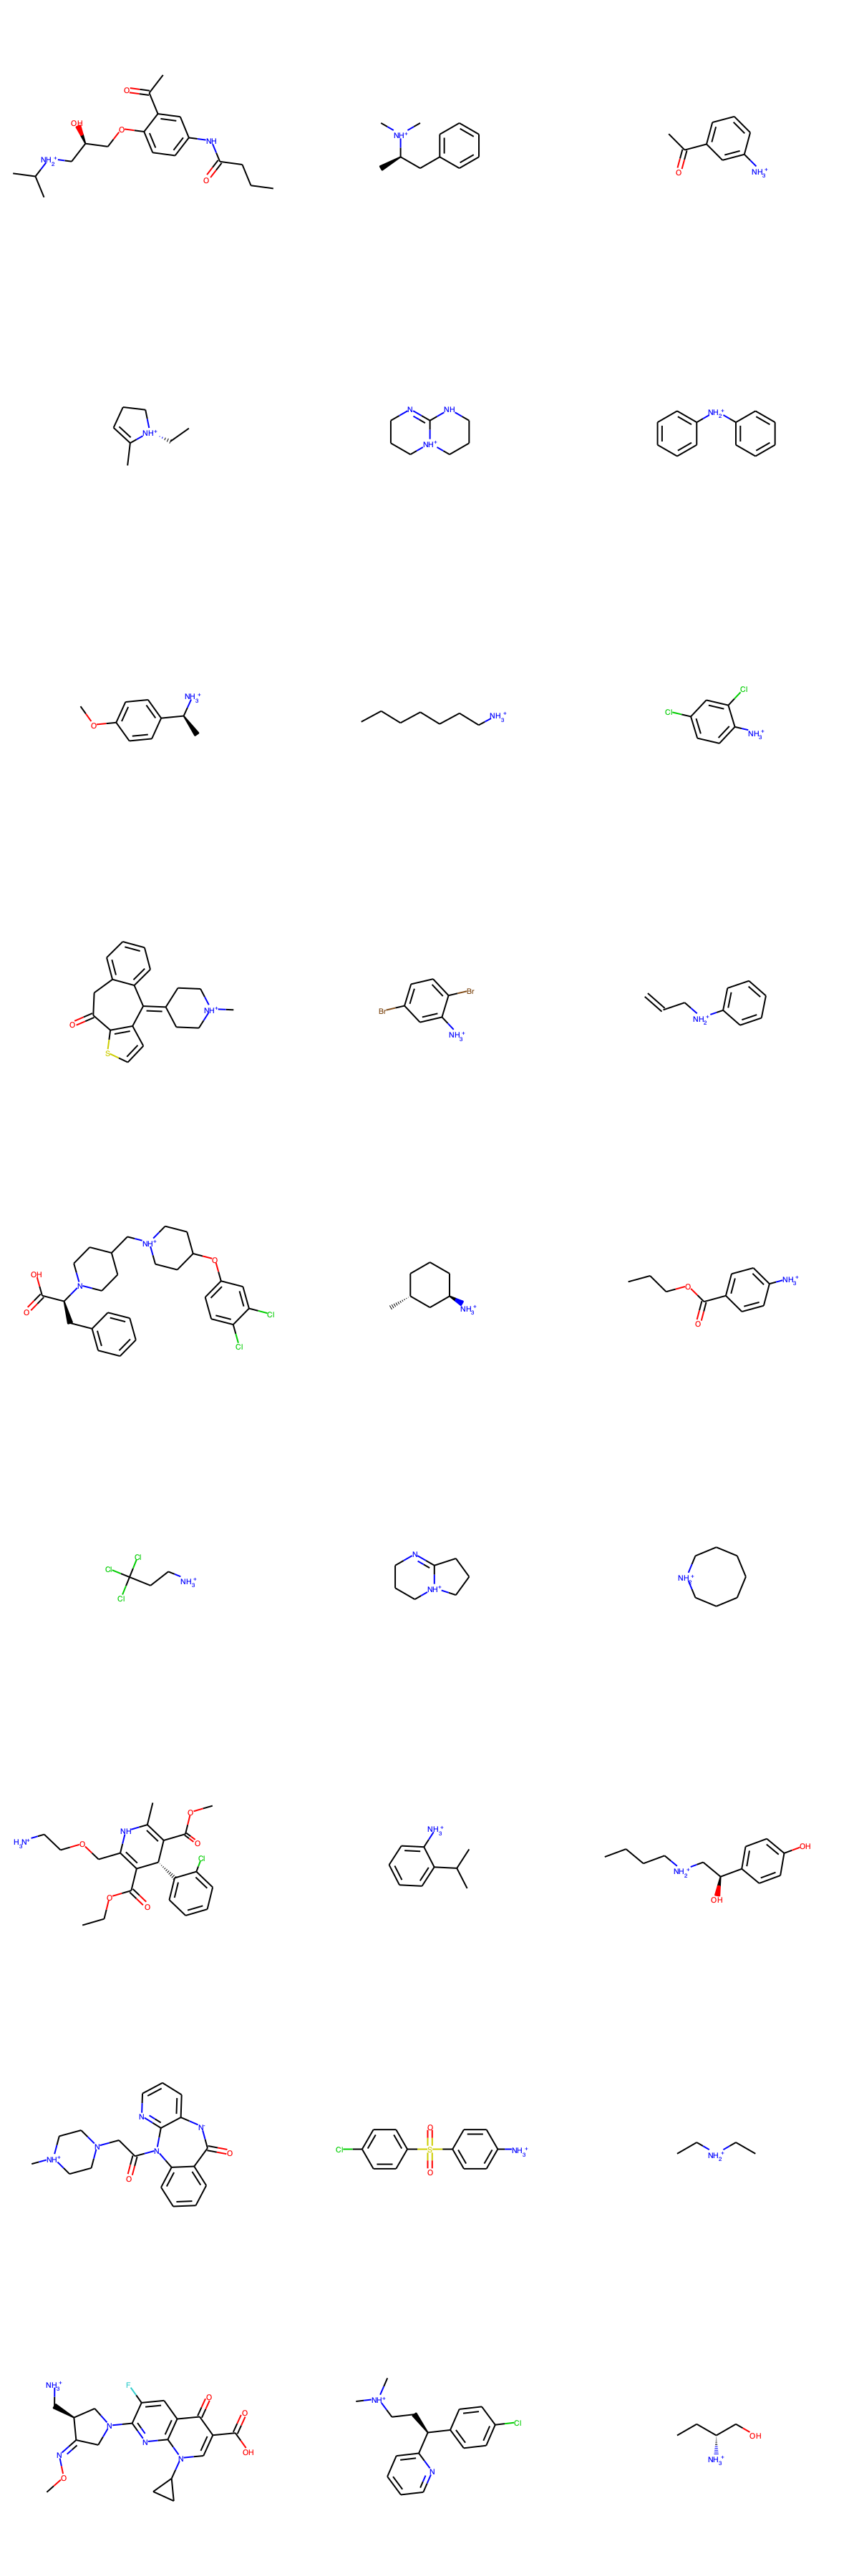

In [439]:
from rdkit import Chem
from rdkit.Chem import Draw, MolToSmiles
print([error[x] for x in range(0,12)])
Draw.MolsToGridImage([Chem.MolFromSmiles(error[x]) for x in range(0,27)], subImgSize=[400,400])

In [111]:
patt_list = [('aromatic carbon','[$([cX3](:*):*),$([cX2+](:*):*)]')]
matches = ddict(list)
for name, smart in patt_list:
    patt = Chem.MolFromSmarts(smart)
    for smile in sol_set:
        mol = Chem.MolFromSmiles(smile)
        if mol.HasSubstructMatch(patt):
            matches[name].append(smile)
    print(name+' matches: '+str(len(matches[name])))

aromatic carbon matches: 2213


In [98]:
featuriser = dc.feat.RDKitDescriptors()
sol = featuriser.featurize('CC')
featuriser.descriptors

['MaxEStateIndex',
 'MinEStateIndex',
 'MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA8',
 'SMR_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA10',
 'SlogP_VSA11',
 'SlogP_VSA12',
 'SlogP_VSA2',
 'SlogP_VSA3',
 'SlogP_VSA4',
 'SlogP_V

In [99]:
rdkit_list = ['HeavyAtomCount',
 'NHOHCount',
 'NOCount',
 'NumAliphaticCarbocycles',
 'NumAliphaticHeterocycles',
 'NumAliphaticRings',
 'NumAromaticCarbocycles',
 'NumAromaticHeterocycles',
 'NumAromaticRings',
 'NumHAcceptors',
 'NumHDonors',
 'NumHeteroatoms',
 'NumRotatableBonds',
 'NumSaturatedCarbocycles',
 'NumSaturatedHeterocycles',
 'NumSaturatedRings',
 'RingCount',
 'MolLogP',
 'MolMR',
 'fr_Al_COO',
 'fr_Al_OH',
 'fr_Al_OH_noTert',
 'fr_ArN',
 'fr_Ar_COO',
 'fr_Ar_N',
 'fr_Ar_NH',
 'fr_Ar_OH',
 'fr_COO',
 'fr_COO2',
 'fr_C_O',
 'fr_C_O_noCOO',
 'fr_C_S',
 'fr_HOCCN',
 'fr_Imine',
 'fr_NH0',
 'fr_NH1',
 'fr_NH2',
 'fr_N_O',
 'fr_Ndealkylation1',
 'fr_Ndealkylation2',
 'fr_Nhpyrrole',
 'fr_SH',
 'fr_aldehyde',
 'fr_alkyl_carbamate',
 'fr_alkyl_halide',
 'fr_allylic_oxid',
 'fr_amide',
 'fr_amidine',
 'fr_aniline',
 'fr_aryl_methyl',
 'fr_azide',
 'fr_azo',
 'fr_barbitur',
 'fr_benzene',
 'fr_benzodiazepine',
 'fr_bicyclic',
 'fr_diazo',
 'fr_dihydropyridine',
 'fr_epoxide',
 'fr_ester',
 'fr_ether',
 'fr_furan',
 'fr_guanido',
 'fr_halogen',
 'fr_hdrzine',
 'fr_hdrzone',
 'fr_imidazole',
 'fr_imide',
 'fr_isocyan',
 'fr_isothiocyan',
 'fr_ketone',
 'fr_ketone_Topliss',
 'fr_lactam',
 'fr_lactone',
 'fr_methoxy',
 'fr_morpholine',
 'fr_nitrile',
 'fr_nitro',
 'fr_nitro_arom',
 'fr_nitro_arom_nonortho',
 'fr_nitroso',
 'fr_oxazole',
 'fr_oxime',
 'fr_para_hydroxylation',
 'fr_phenol',
 'fr_phenol_noOrthoHbond',
 'fr_phos_acid',
 'fr_phos_ester',
 'fr_piperdine',
 'fr_piperzine',
 'fr_priamide',
 'fr_prisulfonamd',
 'fr_pyridine',
 'fr_quatN',
 'fr_sulfide',
 'fr_sulfonamd',
 'fr_sulfone',
 'fr_term_acetylene',
 'fr_tetrazole',
 'fr_thiazole',
 'fr_thiocyan',
 'fr_thiophene',
 'fr_unbrch_alkane',
 'fr_urea']

In [100]:
desc_list = []
from rdkit.Chem import Descriptors
for descriptor, function in Descriptors.descList:
    if descriptor in rdkit_list:
        desc_list.append((descriptor, function))

In [69]:
features = ddict(list)
for desc_name, function in desc_list:
    for smile in sol_set:
        mol = Chem.MolFromSmiles(smile)
        feature = function(mol)
        features[desc_name].append(features)

sol_features = pd.DataFrame(features)
print(sol_features)

KeyboardInterrupt: 

In [101]:
featurizer = dc.feat.RDKitDescriptors()
sol_desc = featurizer.featurize(sol_set)

In [102]:
desc_list2 = featurizer.descriptors
[i for i,x in enumerate(desc_list2) if x == 'HeavyAtomCount']

[96]

In [103]:
sol_desc[0,300]

IndexError: index 300 is out of bounds for axis 1 with size 200

In [ ]:
features = ddict(list)
x = 96
for desc_name in desc_list2[96:]:
    for i in range(len(sol_set)):
        feature = sol_desc[i,x]
        features[desc_name].append(feature)
    x += 1

sol_features = pd.DataFrame(features)
print(sol_features)

In [ ]:
sol_features.to_csv('sol_features.csv')

In [511]:
solute_masses = [MolWt(Chem.MolFromSmiles(mol)) for mol in sol_set]
min(solute_masses)

18.039

In [512]:
max(solute_masses)

1246.153